In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_gaussian_quantiles

### SVM vs. RF on Gaussian

focusing on C today, controlls bias variance tradeoff

In [6]:
# Generate dataset with Gaussian quantiles
X, y = make_gaussian_quantiles(n_samples = 1000,
                               n_features = 2,
                               n_classes = 2,
                               cov = 3.0) # adds noise to the data, allows for overfitting potential to play with

# Introduce additional noise by flipping some labels (0s,1s)
flip_mask = np.random.rand(len(y)) < 0.15
y[flip_mask] = 1 - y[flip_mask]  # flip 15% of the 1000 samples

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

In [7]:
# Set up SVM with RBF kernel and hyperparameter tuning and fit
param_grid_svm = {'C':np.logspace(-2,2,10)} # tuning C in isolation to see how it changes things
grid_search_svm = GridSearchCV(SVC(kernel='rbf',
                                  random_state=808),
                                  param_grid_svm,
                                  cv=5) # Default 5 folds
grid_search_svm.fit(X_train, y_train)


# Best SVM model
best_svm = grid_search_svm.best_estimator_ # pull out the estimator that worked the best
y_train_pred_svm = best_svm.predict(X_train)
y_test_pred_svm = best_svm.predict(X_test)

In [9]:
# Train a Random Forest model with hyperparameter tuning and fit
param_grid_rf = {'n_estimators': [10, 50, 100, 2000],
                'max_depth': [2,5,10,None]}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state = 808),
                             param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=808),
             param_grid={'max_depth': [2, 5, 10, None],
                         'n_estimators': [10, 50, 100, 2000]})

In [10]:
# Best RF model
best_rf = grid_search_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

In [12]:
# Compute accuracy for both models
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"SVM Train Accuracy: {train_acc_svm:.2f}, Test accuracy: {test_acc_svm:.2f}")
print(f"RF Train Accuracy: {train_acc_rf:.2f}, Test accuracy: {test_acc_rf:.2f}")

SVM Train Accuracy: 0.86, Test accuracy: 0.90
RF Train Accuracy: 0.95, Test accuracy: 0.87


Ultimately, SVM has better accuracy on the testing data so we would choose that one.
Seems like RF overfit quite a bit, performing better on the training than the test data. 

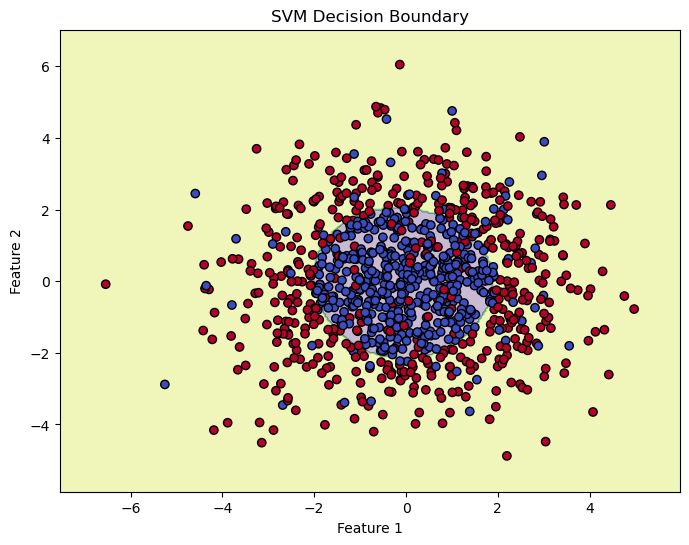

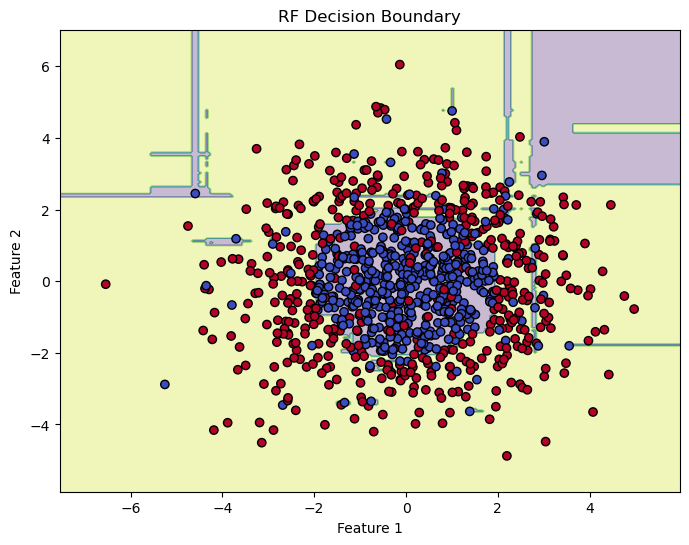

In [13]:
# Function to visualize decision boundaries
def plot_decision_boundary(model, X, y, title):
    h = 0.05  # Step size in the mesh
    
    # Define the range for plotting based on feature values
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the class for each point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Reshape predictions to match the grid shape for contour plotting
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

# Visualize decision boundaries
plot_decision_boundary(best_svm, X, y, "SVM Decision Boundary")
plot_decision_boundary(best_rf, X, y, "RF Decision Boundary")

The random forest model fell for the "red herring" outliers, trying to fit them using complicated decisions. Overfitting!


### Effect of C parameter on overfitting

In [17]:
# Test different values of C in SVM with an RBF kernel
C_values = np.logspace(-3,3,10) # iterate from -3 to 3, with 10 values
train_scores_svm = []
test_scores_svm = []

# Fit a series of SVM, varying C
for C in C_values:
    svm = SVC(kernel = 'rbf', # holding kernel parameter constant
              C = C,  # iterating here
              random_state = 808)
    svm.fit(X_train, y_train)
    
    # Compute train and test accuracy
    train_scores_svm.append(accuracy_score(y_train, svm.predict(X_train)))
    test_scores_svm.append(accuracy_score(y_test, svm.predict(X_test)))

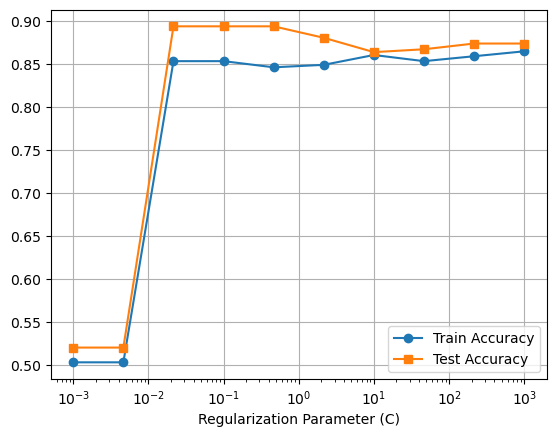

In [18]:
# Plot Learning Curve: Training vs. Test Accuracy
plt.plot(C_values, train_scores_svm, 
         marker = 'o', 
         label = "Train Accuracy")

plt.plot(C_values, test_scores_svm, 
         marker = 's', 
         label = "Test Accuracy")

plt.xscale("log")

plt.xlabel("Regularization Parameter (C)")
plt.legend()
plt.grid(True)
plt.show()